In [14]:
import os

import numpy as np
import pandas as pd
import networkx as nx

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from IPython.display import HTML, display

# Import the data

In [2]:
with open(os.path.join('pickle', 'conflict.pickle'), 'rb') as src:
    events = pickle.load(src)
    
events.type_of_violence = events.type_of_violence.astype('category')
events.where_prec       = events.where_prec.astype('category')
events.type_of_violence.cat.rename_categories(['state-based', 'non-state', 'one-sided'], inplace=True)

In [3]:
events.head(2)

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,country,country_id,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,state-based,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,Yemen (North Yemen),678,Middle East,2010,2010,2,0,0,0,2
1,5,2011,one-sided,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,Yemen (North Yemen),678,Middle East,2011,2011,0,0,0,0,0


# Combining events into conflicts

The fundental unit of the dataset is the event. However we are interested in conflicts. Therefore we group events into conflicts and aggregate some of the features:

- `date_start` and `date_end` are combined to obtain a length for each event that will be summed across all events.
- `date_start` becomes the oldest date in the list of start dates of the events in a conflict.
- `date_end` similarly becomes the most recent
- all the deaths counts are summed.
- A list of all sides, countries and coordinates is kept for each conflict
- A list of regions in which the conflict took place is kept as well

In [4]:
format = '%Y-%m-%d'
events['date_start'] = pd.to_datetime(events.date_start, format=format)
events['date_end'] = pd.to_datetime(events.date_end, format=format)
events['duration'] = events.date_end - events.date_start

In [5]:
conflicts = events.groupby('conflict_new_id').agg({
    'duration': 'sum',
    'date_start': 'min',
    'date_end': 'max',
    'deaths_civilians': 'sum',
    'deaths_unknown': 'sum',
    'best': 'sum',
    'latitude': lambda x: list(x),
    'longitude': lambda x: list(x),
    'country': lambda x: set(x),
    'side_a': lambda x: list(x),
    'side_b': lambda x: list(x),
    'region' : lambda x: set(x)
})

We use the provided conflict id to index the data:

In [6]:
names = events[['conflict_new_id', 'conflict_name']].drop_duplicates()\
                                                    .set_index('conflict_new_id').conflict_name

In [7]:
conflicts['name'] = names

In [8]:
conflicts = conflicts.rename(columns={
    'country': 'countries',
    'side_a': 'sides_a',
    'side_b': 'sides_b',
    'latitude': 'latitudes',
    'longitude': 'longitudes'
})

In [9]:
conflicts.head()

,duration,date_start,date_end,deaths_civilians,deaths_unknown,best,latitudes,longitudes,countries,sides_a,sides_b,region,name
conflict_new_id,,,,,,,,,,,,,
205,0 days,1990-01-01,2016-01-01,92,56,218,"[36.246389, 36.155278, 37.32322, 35.73671, 36....","[46.266389, 45.478889, 48.041134, 46.274843, 4...","{Iraq, Iran, Germany, Turkey}","[Government of Iran, Government of Iran, Gover...","[KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDP...","{Middle East, Europe}",Iran:Kurdistan
209,0 days,1989-01-01,2016-01-01,276,221,7786,"[12.782008, 7.780424, 12.75, 8.895, 12.4863, 1...","[123.952024, 123.292649, 124.033333, 125.77527...",{Philippines},"[Government of Philippines, Government of Phil...","[CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, ...",{Asia},Philippines:Government
218,0 days,1989-01-01,2016-01-01,187,331,1701,"[34.57173, 34.683056, 34.484389, 33.831266, 34...","[73.89724, 76.645, 75.658389, 74.046931, 73.85...","{India, Pakistan}","[Government of India, Government of India, Gov...","[Government of Pakistan, Government of Pakista...",{Asia},Government of India-Government of Pakistan
220,0 days,1989-01-01,1989-01-01,0,150,150,[-25.29389],[-57.611111],{Paraguay},[Government of Paraguay],[Military faction (forces of Andres Rodriguez)],{Americas},Paraguay:Government
221,0 days,1989-01-01,2015-01-01,196,1366,4550,"[17.5, 17.5, 17.5, 17.5, 17.5, 17.5, 22.0, 17....","[97.75, 97.75, 97.75, 97.75, 97.75, 97.75, 98....","{Thailand, Myanmar (Burma)}","[Government of Myanmar (Burma), Government of ...","[KNU, KNU, KNU, KNU, KNU, DKBA 5, KNU, KNU, KN...",{Asia},Myanmar (Burma):Karen


We look for the conflicts with the most casualties:

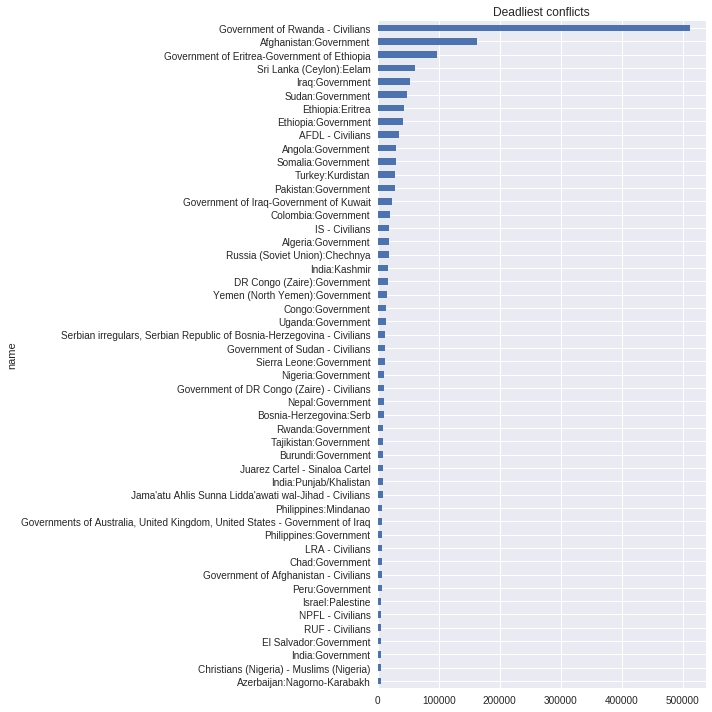

In [10]:
ax = conflicts[['name', 'best']].sort_values(by='best')[-50:].set_index('name')\
                                .plot(kind='barh', figsize=(10,10), title='Deadliest conflicts')
ax.legend().set_visible(False)
plt.tight_layout()
#plt.savefig('deadliest-conflicts.png') # Save for data story

# Analyzing factions (sides)

## Create the dataframe with one record per (side_a, side_b)

We aggregate the data to have one record per each couple `(side_a, side_b)` to create a dataframe to use as basis for our analysis of factions.

First we create a simple dataframe with a record per side:

In [11]:
sides_a = events[['side_a_new_id', 'side_a']]
sides_a.columns = ['id', 'name']
sides_a = sides_a.set_index('id')

sides_b = events[['side_b_new_id', 'side_b']]
sides_b.columns = ['id', 'name']
sides_b = sides_b.set_index('id')

sides = pd.concat([sides_a, sides_b]).drop_duplicates()

print('The total number of sides is {}'.format(len(sides)))

The total number of sides is 1143


We then group the data by the tuple `(side_a, side_b)` and keep for each entry the total number of dead, the dead per side and the region. Finally we merge everything in a single dataframe.

In [20]:
# Aggregate data
sides_victims = events.groupby(['side_a_new_id', 'side_b_new_id']).best.sum()
sum_victims_a = events.groupby(['side_a_new_id', 'side_b_new_id']).deaths_a.sum()
sum_victims_b = events.groupby(['side_a_new_id', 'side_b_new_id']).deaths_b.sum()

# Build new dataframe
sides_victims = pd.DataFrame({
    'dead': sides_victims,
    'dead_a': sum_victims_a,
    'dead_b': sum_victims_b
}).reset_index()

# Merge to have side names
sides_victims = sides_victims.merge(sides, left_on='side_a_new_id', right_index=True)
sides_victims = sides_victims.merge(sides, left_on='side_b_new_id', right_index=True)

# Rename columns and sort
sides_victims.columns = ['id_a', 'id_b', 'dead', 'dead_a', 'dead_b', 'name_a', 'name_b']
sides_victims.sort_values(by='dead', inplace=True, ascending=False)

# Prepare region data
region = events[['side_a_new_id', 'side_b_new_id', 'region']]
region = pd.DataFrame(region.groupby(['side_a_new_id', 'side_b_new_id']).region.apply(set))
region = pd.DataFrame(region)
region.columns = ['setRegion']
region = region.reset_index()
region = region[['side_a_new_id', 'side_b_new_id', 'setRegion']]
region.columns = ['id_a', 'id_b', 'region']

sides_victims = sides_victims.merge(region, on=['id_a', 'id_b'])
sides_victims['dead_sides'] = sides_victims.dead_a + sides_victims.dead_b

In [21]:
sides_victims.head(10)

,id_a,id_b,dead,dead_a,dead_b,name_a,name_b,region,dead_sides
0,94,1,511531,0,0,Government of Rwanda,Civilians,{Africa},0
1,130,303,107344,23596,67146,Government of Afghanistan,Taleban,{Asia},90742
2,98,97,97435,13817,5140,Government of Eritrea,Government of Ethiopia,{Africa},18957
3,145,320,60697,14462,37568,Government of Sri Lanka,LTTE,"{Asia, Europe}",52030
4,116,234,47859,9487,25570,Government of Iraq,IS,"{Middle East, Africa, Europe}",35057
5,97,416,43470,42900,0,Government of Ethiopia,EPLF,{Africa},42900
6,97,414,41269,39893,376,Government of Ethiopia,EPRDF,{Africa},40269
7,422,1,35126,0,0,AFDL,Civilians,{Africa},0
8,112,466,31240,14283,3201,Government of Sudan,SPLM/A,{Africa},17484
9,99,567,30222,1284,7596,Government of Angola,UNITA,{Africa},8880


We export the json to use with [d3](https://d3js.org/) to build the chord diagrams for the datastory.

In [22]:
sides_victims.to_json(os.path.join('results', 'sides.json'), orient='records') # Export to json to build visualizations

## Create a network of sides

We create a graph where each node is a side and each edge is an event the involved two sides. We also use `networkx` built in draw functions to have an idea of the structure of the graph.

In [24]:
sides_net = nx.from_pandas_dataframe(sides_victims[:100], source='name_a', target='name_b', edge_attr='dead')

/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


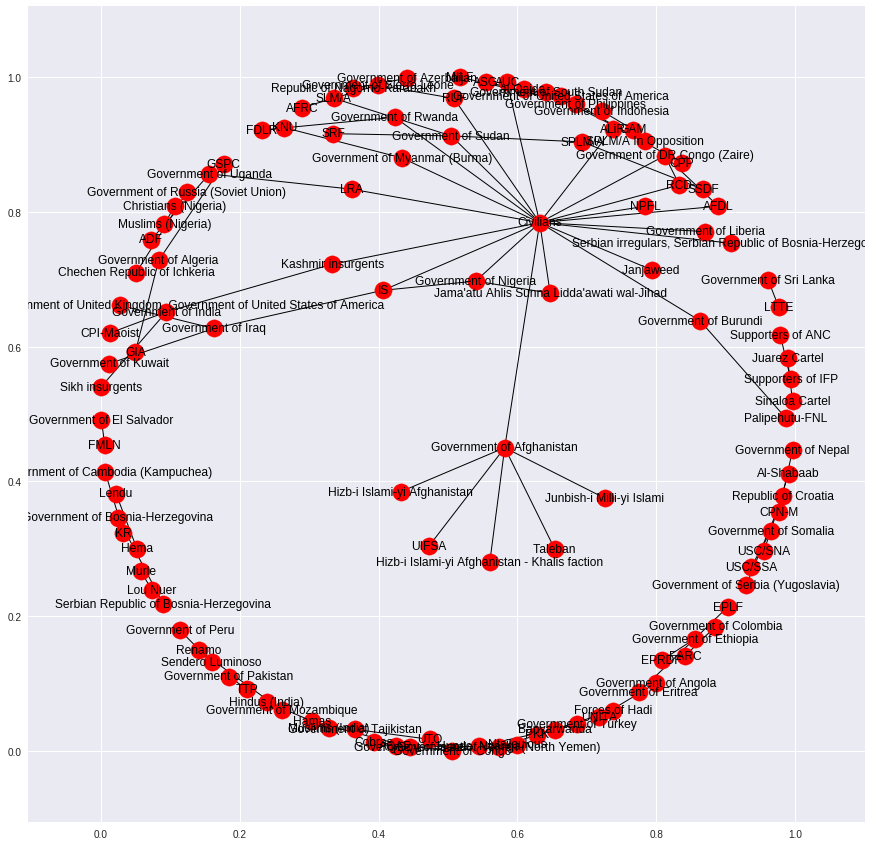

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(sides_net, ax=ax)

We look at the degree distribution of the network:

In [28]:
faction, degree = zip(*map(tuple, sides_net.degree().items()))

In [29]:
def degree_distribution(degrees):
    c = Counter()
    for deg in degrees:
        c[deg] += 1
    return c

In [30]:
degree, count = zip(*sorted(degree_distribution(degree).items(), key=lambda k: k[0]))

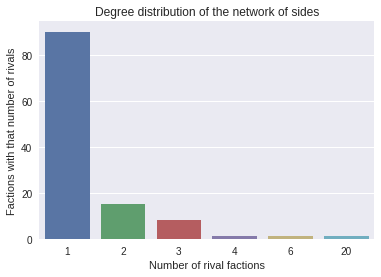

In [31]:
ax = sns.barplot(degree, count)
ax.set_title('Degree distribution of the network of sides')
ax.set_xlabel('Number of rival factions')
ax.set_ylabel('Factions with that number of rivals')
plt.savefig('degree-distribution-sides.png')

We see that most of the faction only fought against one opponent. There is no "big villain" who tries to conquer the world.
As most of the nodes have degree 1, it is not really a graph.

As we characterized each edge with the number of dead people for that pair of sides, we can visualize this as a flow using a sankey diagram. The color and width of the edges varies from blue to red proportionally to the number of victims.
Here is the graph for the top 20 most deadly rivalities

![sankey](results/sankey.svg)

In addition that, when we have enough precision in the data such that the $victims_{a} + victims_{b} = total$ we can use a chord diagram to visualize, for the nodes with degree bigger than one, the proportion of victims caused by each enemy:

![chord](results/chord.png)